In [1]:
import numpy as np
from collections import deque
from heapq import heappush, heappop

In [2]:
def watershed(image, points, type='standard'):
    def prepare(image, points, type='standard'):
        def image_gradient(image):
            grad_list = np.gradient(image)
            if len(image.shape) == 2:
                return np.sqrt(grad_list[0] ** 2 + grad_list[1] ** 2).astype(int)
            elif len(image.shape) == 3:
                return np.sqrt(grad_list[0] ** 2 + grad_list[1] ** 2 + grad_list[2] ** 2).astype(int)
    
        gradient = image_gradient(image)
        flag = np.zeros(image.shape) == 1
        mask = np.zeros(image.shape).astype(np.int)
        if type == 'standard':
            queue = []
            c = 0
            for i in range(len(points)):
                flag[points[i]] = True
                mask[points[i]] = i + 1
                heappush(queue, ((gradient[points[i]], c), points[i]))
                c += 1
            return gradient, flag, mask, c, queue
        elif type == 'hierarchical':
            queues = [deque() for i in range(np.max(gradient) + 1)]
            for i in range(len(points)):
                flag[points[i]] = True
                mask[points[i]] = i + 1
                queues[gradient[points[i]]].append(points[i])
            return gradient, flag, mask, queues

    if type == 'standard':
        gradient, flag, mask, c, queue = prepare(image, points)
        while len(queue) != 0:
            if len(image.shape) == 2:
                x, y = heappop(queue)[1]
                neighbors = [(x-1, y), (x+1, y), (x, y+1), (x, y-1)]
                for nb in neighbors:
                    if 0 <= nb[0] < gradient.shape[0] and \
                    0 <= nb[1] < gradient.shape[1]:
                        if not flag[nb]:
                            flag[nb] = True
                            mask[nb] = mask[x, y]
                            heappush(queue, ((gradient[nb], c), nb))
                            c += 1
            elif len(image.shape) == 3:
                x, y, z = heappop(queue)[1]
                neighbors = [(x-1, y, z), (x+1, y, z), (x, y+1, z),
                             (x, y-1, z), (x, y, z+1), (x, y, z-1)]
                for nb in neighbors:
                    if 0 <= nb[0] < gradient.shape[0] and \
                    0 <= nb[1] < gradient.shape[1] and  \
                    0 <= nb[2] < gradient.shape[2]:
                        if not flag[nb]:
                            flag[nb] = True
                            mask[nb] = mask[x, y, z]
                            heappush(queue, ((gradient[nb], c), nb))
                            c += 1
    elif type == 'hierarchical':
        gradient, flag, mask, queues = prepare(image, points, 'hierarchical')
        for i in range(len(queues)):
            while len(queues[i]) != 0:
                if len(image.shape) == 2:
                    x, y = queues[i].popleft()
                    neighbors = [(x - 1, y), (x + 1, y), (x, y + 1), (x, y - 1)]
                    for nb in neighbors:
                        if 0 <= nb[0] < gradient.shape[0] and \
                        0 <= nb[1] < gradient.shape[1]:
                            if not flag[nb]:
                                flag[nb] = True
                                mask[nb] = mask[x, y]
                                queues[max(gradient[nb], i)].append(nb)
                elif len(image.shape) == 3:
                    x, y, z = queues[i].popleft()
                    neighbors = [(x-1, y, z), (x+1, y, z), (x, y+1, z),
                                 (x, y-1, z), (x, y, z+1), (x, y, z-1)]
                    for nb in neighbors:
                        if 0 <= nb[0] < gradient.shape[0] and \
                        0 <= nb[1] < gradient.shape[1] and \
                        0 <= nb[2] < gradient.shape[2]:
                            if not flag[nb]:
                                flag[nb] = True
                                mask[nb] = mask[x, y, z]
                                queues[max(gradient[nb], i)].append(nb)
    else:
        raise ValueError("Wrong parameter of type")
    return mask

In [3]:
from datetime import datetime
from matplotlib import pyplot as plt
from skimage.io import imshow, imshow_collection
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'imshow']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [42]:
image_2d = np.fromfile("circles.raw", dtype=np.int8).reshape(500, 500)
points_2d = [(i+50, i) for i in range(0, 500, 100)]

Результаты работы различных версий алгоритма для двумерного изображения: способ с иерархической приоритетной очередью работает быстрее.


Evaluating algorithm with standard priority queue for circles:
Elapsed time: 6.6 sec


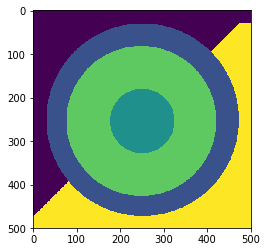


Evaluating algorithm with hierarchical priority queue for circles:
Elapsed time: 4.2 sec


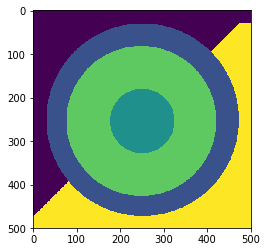

/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:2907: RuntimeWarning: overflow encountered in byte_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


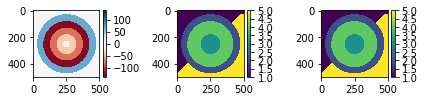

In [41]:
print('\nEvaluating algorithm with standard priority queue for circles:')
start = time.time()
res_standard = watershed(image_2d, points_2d)
print('Elapsed time: {0:.1f} sec'.format(time.time() - start))
imshow(res_standard, cmap=cm.viridis)
plt.show()

print('\nEvaluating algorithm with hierarchical priority queue for circles:')
start = time.time()
res_hierarchical = watershed(image_2d, points_2d, 'hierarchical')
print('Elapsed time: {0:.1f} sec'.format(time.time() - start))
imshow(res_hierarchical, cmap=cm.viridis)
plt.show()

imshow_collection([image_2d, res_standard, res_hierarchical])

Результаты работы различных версий алгоритма для трёхмерного изображения: способ с иерархической приоритетной очередью работает значительно быстрее, как и ожидалось.

In [4]:
image_3d = np.fromfile("id018.raw", dtype=np.int16).reshape(512, 512, 100)

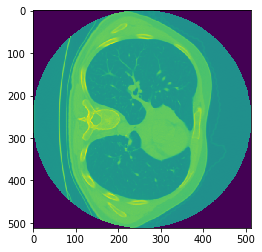

In [5]:
imshow(image_3d[:,:,50])

In [7]:
points_3d = [(1, 1, 50), (498, 1, 50), (1, 498, 50), (498, 498, 50), 
             (400, 250, 50), (140, 330, 50), (200, 20, 50), (200, 450, 50),
             (300, 300, 50), (70, 200, 50), (470, 200, 50)]

In [8]:
print('\nEvaluating algorithm with standard priority queue for 3d-image:')
start = time.time()
res_standard = watershed(image_3d, points_3d)
print('Elapsed time: {0:.1f} sec'.format(time.time() - start))

print('\nEvaluating algorithm with hierarchical priority queue for 3d-image:')
start = time.time()
res_hierarchical = watershed(image_3d, points_3d, 'hierarchical')
print('Elapsed time: {0:.1f} sec'.format(time.time() - start))


Evaluating algorithm with standard priority queue for 3d-image:
Elapsed time: 1379.8 sec

Evaluating algorithm with hierarchical priority queue for 3d-image:
Elapsed time: 641.2 sec


/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


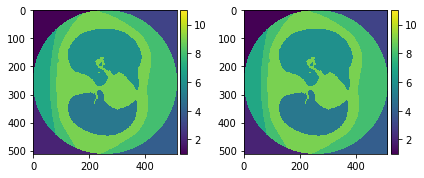

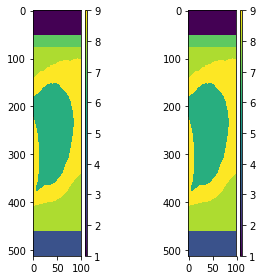

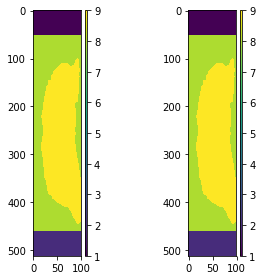

In [9]:
imshow_collection([res_standard[:,:,50], res_hierarchical[:,:,50]])
imshow_collection([res_standard[100,:,], res_hierarchical[100,:,]])
imshow_collection([res_standard[:,100,], res_hierarchical[:,100,]])